# Group 005 Real Estate Analysis

## Setup and Load Data

First, we retrieve the dataste from https://www.kaggle.com/datasets/mrdaniilak/russia-real-estate-20182021.

If using the below cell, make sure you have a Kaggle API token in a `kaggle.json` file in `~/.kaggle/`. Otherwise, please download the data manually and place it under a folder `./data/`.

In [1]:
# !mkdir data
# !kaggle datasets download mrdaniilak/russia-real-estate-20182021
# !mv ./russia-real-estate-20182021.zip ./data/russia-real-estate-20182021.zip

In [2]:
# import zipfile
# with zipfile.ZipFile('./data/russia-real-estate-20182021.zip', 'r') as zip_ref:
#     zip_ref.extractall('./data')

Now, we may proceed with exploration.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
DATA_CSV_PATH = './data/all_v2.csv'

# load csv data
df = pd.read_csv(DATA_CSV_PATH)

# remove duplicate data
df = df.drop_duplicates()

In [5]:
df.sample(5)

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
879177,3200000,2019-01-02,16:22:24,56.338597,37.552147,81,0,9,17,1,42.0,10.0,1
397715,33000000,2018-11-01,22:02:58,55.710423,37.476017,3,2,6,15,4,166.0,20.0,1
4927189,2600000,2021-01-11,06:46:20,54.966377,82.903741,9654,3,4,4,2,55.0,9.0,1
2221993,4546940,2019-07-17,14:48:12,59.998324,30.300965,2661,2,7,25,1,36.1,15.7,11
1811995,8000000,2019-05-17,15:54:05,55.793571,37.489284,3,3,1,5,1,42.0,8.0,1


Note that this Kaggle Dataset was originally pulled from GeoNames (http://www.geonames.org/), which has its own "regions" separated by county. Our city of interest, Moscow, has ID 81.

Addtionally, we will give categorical data appropriate labels given by the dataset spec.

Finally, while the dataset used Russian rubles for real estate price, we use US Dollars for more interpretable loss (since the Ruble prices are in the millions, and since we are more familiar with the US Dollar).

In [6]:
MOSCOW_CODE = 81
MAX_NUM_SAMPLES = 100000
SEED = 69

RUBLE_TO_DOLLAR = 0.012

moscow_df = df.loc[df['region'] == MOSCOW_CODE]
moscow_df = moscow_df.drop(['time', 'geo_lat', 'geo_lon', 'region'], axis=1)
moscow_df['date'] = moscow_df['date'].apply(lambda x: int(x[:4]))

moscow_df['object_type'] = moscow_df['object_type'].replace(1, 'preowned').replace(11, 'new')
moscow_df['building_type'] = moscow_df['building_type'].replace(0, 'other').replace(1, 'panel').replace(2, 'monolithic').replace(3, 'brick').replace(4, 'blocky').replace(5, 'wooden')

# -1 means studio apartment, so we replace with 0 (since studio apartments have no extra rooms)
# there are not other datapoints with value 0
moscow_df['rooms'] = moscow_df['rooms'].replace(-1, 0)

# remove rows with errorneous data
moscow_df = moscow_df[moscow_df['price'] >= 0]
moscow_df = moscow_df[moscow_df['rooms'] >= 0]

#  convert to US dollar per conversion rate as of June 12, 2023
moscow_df['price'] = moscow_df['price'] * RUBLE_TO_DOLLAR

# cap number of elements
moscow_df = moscow_df.sample(MAX_NUM_SAMPLES, random_state=SEED)

In [7]:
moscow_df.isnull().values.any()

False

In [8]:
moscow_df.sample(5)

,price,date,building_type,level,levels,rooms,area,kitchen_area,object_type
1858860,13200.00,2019,monolithic,2,4,1,38.0,8.0,preowned
2641560,63600.00,2019,brick,3,5,3,61.0,6.0,preowned
1960040,38400.00,2019,monolithic,16,17,1,44.0,12.0,new
2949792,37200.00,2019,brick,13,16,0,32.0,7.0,preowned
2975501,76102.32,2019,panel,11,25,2,67.9,20.3,new


## Exploration

First, we'll look at the data distributions for the ordinal data.

In [9]:
moscow_df.describe()

,price,date,level,levels,rooms,area,kitchen_area
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,5.707663e+04,2019.310120,7.053700,12.752370,1.776320,51.592710,10.362995
std,3.556933e+04,0.880621,5.692804,7.411351,0.862656,21.748209,6.834285
min,1.800000e+01,2018.000000,1.000000,1.000000,0.000000,2.400000,0.120000
25%,3.600000e+04,2019.000000,3.000000,5.000000,1.000000,38.000000,7.000000
50%,5.160000e+04,2019.000000,5.000000,12.000000,2.000000,46.000000,9.700000
75%,7.140000e+04,2020.000000,10.000000,17.000000,2.000000,61.900000,12.000000
max,3.572896e+06,2021.000000,36.000000,38.000000,9.000000,997.000000,1131.000000


Each column is skewed right, meaning we have some extreme outliers for each column. This is because in the real estate market, while most "normal" places have a similar price, the price ceiling for real estate can be very high. While these outliers are sparse, they could still bias our model.

Next, we can plot each variable against price to look for possible correlations. We will only looks at data points with price less than $2 \cdot 10^7$ to get better plots by removing price outliers. We will also plot regression lines for each to quantify per-variable correlation strength.

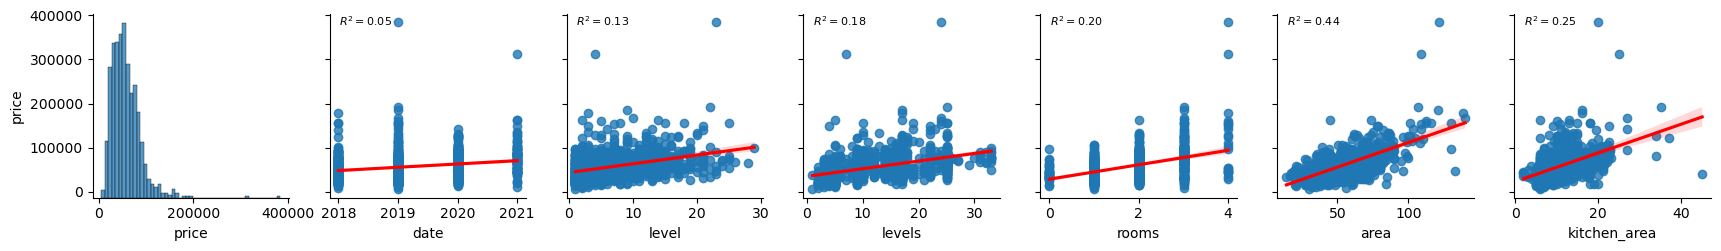

In [10]:
from scipy.stats import linregress

def calc_R2(x, y, ax=None, **kwargs):
    ax = ax or plt.gca()
    _, _, r_value, _, _ = linregress(x=x, y=y)
    ax.annotate(f'$R^2 = {r_value ** 2:.2f}$', xy=(.05, 1), xycoords=ax.transAxes, fontsize=8, ha='left', va='top')

g = sns.pairplot(moscow_df.loc[moscow_df['price'] < 2e7].sample(1000, random_state=21), kind='reg', y_vars=['price'], plot_kws={'line_kws':{'color':'red'}})

g.map_upper(calc_R2)
plt.show()

Data and level have near-zero correlations. The number of levels in the building (i.e. building size) and number of rooms, as well have kitchen area, seem like they might have some signidicance. The most important (single) variable seems to be area. However, even here we don't have a strong correlation. Hopefully combining these variables into a multivariate regression will lead to stronger correlation.

Additionally, all of the correlations seem to be closest to linear (as opposed to some polynomial fit). So, a polynomial regression may not perform better than a linear regression.

However, in the above we only use about 1000 samples (for efficiency). We can see these correlation results across the dataset more easily with a heatmap:

<Axes: >

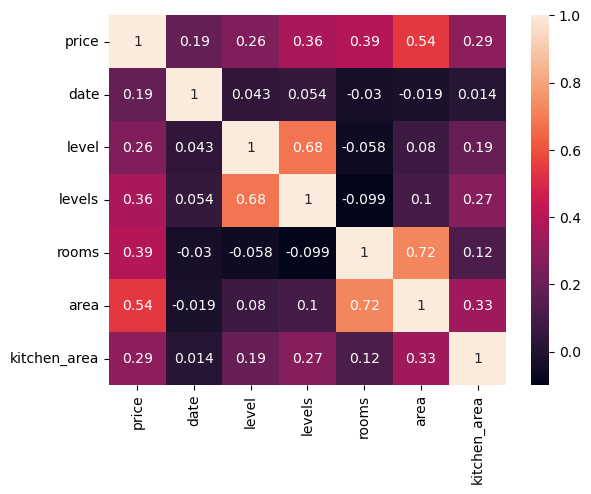

In [11]:
sns.heatmap(moscow_df.drop(['building_type', 'object_type'], axis=1).corr(), annot=True)

Notably, `date` and `level` have a stronger correlation than from our 1000 samples, but each individual variable still does not have a strong enough correlation for prediction.

Thus, we proceed to fitting some models.

## Preprocessing Data for Models

In [12]:
from sklearn.model_selection import train_test_split

X = moscow_df[['date', 'building_type', 'level', 'levels', 'rooms', 'area', 'kitchen_area', 'object_type']]
y = moscow_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

print(f'{len(y_train)} train samples; {len(y_test)} test samples')

70000 train samples; 30000 test samples


Now, we will one-hot the categorical data using sklearn's one hot encoder.

In [13]:
from sklearn.preprocessing import OneHotEncoder

for col in ['building_type', 'object_type']:

    one_hot = OneHotEncoder()
    one_hot.fit(X_train[[col]])

    X_train.loc[:, one_hot.categories_[0]] = one_hot.transform(X_train[[col]]).todense()
    X_test.loc[:, one_hot.categories_[0]] = one_hot.transform(X_test[[col]]).todense()

    X_train = X_train.drop(col, axis=1)
    X_test = X_test.drop(col, axis=1)

X_train.sample(5)

,date,level,levels,rooms,area,kitchen_area,blocky,brick,monolithic,other,panel,wooden,new,preowned
4830599,2020,1,9,3,61.1,11.9,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2995395,2019,3,5,4,77.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
904020,2019,4,22,1,32.7,7.6,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1072127,2019,4,8,1,32.2,8.3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4248320,2020,2,5,4,59.2,6.8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


Next, we will scale the data. Note that not all models require scaled data; while models like linear regression require scaling to avoid overemphasis of certain datapoints, models like descision trees (and, by extension, random forests) are not affected by unscaled variables (though, of course, scaled data won't negatively impact performance models like descision trees, either).

In [14]:
from sklearn.preprocessing import StandardScaler

ordinal_cols = ['date', 'level', 'levels', 'rooms', 'area', 'kitchen_area']
X_train_ordinal, X_test_ordinal = X_train[ordinal_cols], X_test[ordinal_cols]

scaler = StandardScaler()
scaler.fit(X_train_ordinal)

X_train_scaled, X_test_scaled = X_train, X_test

X_train_scaled.loc[:, scaler.feature_names_in_] = scaler.transform(X_train_ordinal)
X_test_scaled.loc[:, scaler.feature_names_in_] = scaler.transform(X_test_ordinal)

X_train_scaled.sample(5)

,date,level,levels,rooms,area,kitchen_area,blocky,brick,monolithic,other,panel,wooden,new,preowned
2116713,-0.350955,-0.364642,-0.782061,-0.900040,-0.512793,0.053876,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2930667,-0.350955,-0.892245,-1.456962,1.415813,0.883223,-0.184227,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3369617,0.784297,-0.716377,0.162800,0.257887,0.290144,0.477171,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4076668,0.784297,3.152715,1.782561,1.415813,2.247303,0.225839,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
884243,-0.350955,1.218169,0.432760,0.257887,1.042898,0.741730,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [15]:
gkeokde

NameError: name 'gkeokde' is not defined

## Model Fitting

When we began training models, an immediate issue presented itself: we didn't have sufficient compuational resources to handle very large data using only Sklearn's cpu-only implenetaions. This made training very slow and hyperparameter tuning out of the question.

Thus, we implement Nvidia's [RAPIDS](https://rapids.ai/) API, which offers models with similar syntax to Sklearn, but with GPU acceleration. In particular, RAPIDS includes the CuML package, which accelerates training significantly. (For example, when training our Random Forests, one hyperparam test took Sklearn hours, while RAPIDS completed the same task in mere seconds).

The main challenge with using RAPIDS was technical implementation: we acheived most stability on WSL2 Ubuntu on Windows with CUDA 11.5.

### Rapids CuML Setup

First, we convert our data using CuDF and CuPY to allow our CuML models to use GPU acceleration.

In [19]:
import cudf
import cupy as cp

def to_cudf(pd_df):
    data = dict()

    for col in pd_df.columns:
        data[col] = pd_df[col].to_numpy(dtype=np.float32)

    return cudf.DataFrame(data)

def to_cupy(pd_df):
    return cp.from_dlpack(pd_df.to_dlpack())

In [20]:
X_train_cudf = to_cudf(X_train)
X_test_cudf = to_cudf(X_test)

X_train_cupy = to_cupy(X_train_cudf)
X_test_cupy = to_cupy(X_test_cudf)

In [21]:
X_train_scaled_cudf = to_cudf(X_train_scaled)
X_test_scaled_cudf = to_cudf(X_test_scaled)

X_train_scaled_cupy = to_cupy(X_train_scaled_cudf)
X_test_scaled_cupy = to_cupy(X_test_scaled_cudf)

In [22]:
y_train_cudf = cudf.Series(y_train.to_numpy())
y_test_cudf = cudf.Series(y_test.to_numpy())

y_train_cupy = to_cupy(y_train_cudf)
y_test_cupy = to_cupy(y_test_cudf)

Next, we found that Sklearn's `GridSearchCV` and `RandomizedSearchCV` were somewhat unstable with RAPIDS on our machines; in particular, there seemed to be some issues regarding the way Sklearn creates new models for hyperparam tuning.

For this reason, we create a `custom_grid_search` function which, though containing fewer features, is more stable with RAPIDS.

In [23]:
from sklearn.metrics import mean_absolute_error

def custom_grid_search(model, hparams, default_kwargs, X_train_cupy, y_train_cupy,
                       folds=3, verbose=0):
    import itertools
    
    # note that the KFold class in SciKit by default does not use shuffling, so we will not implement shuffling here
    X_splits = cp.array_split(X_train_cupy, folds)
    y_splits = cp.array_split(y_train_cupy, folds)
    cv_scores = dict()

    # we use the same model instance to avoid RAPIDS crashing
    cuml_model = model(**default_kwargs)
    for hparam_comb in itertools.product(*hparams.values()):
        kwargs = dict(zip(hparams.keys(), hparam_comb))
        
        holdouts = []
        
        if verbose >= 1:
            print(f'Training CV with {folds} folds on hparams {kwargs}')

        # setting new params seems more stable on CuML
        cuml_model.set_params(**kwargs, **default_kwargs)
        
        for i in range(folds):
            
            # train data is everything except hold-out
            train_sets = [X_splits[j] for j in range(len(X_splits)) if j != i]
            label_sets = [y_splits[j] for j in range(len(y_splits)) if j != i]
                
            train_arr = cp.vstack(train_sets)
            labels_arr = cp.hstack(label_sets)
            cuml_model.fit(train_arr, labels_arr)
            
            # get pred error using hold-out
            preds = cuml_model.predict(X_splits[i])   
            score = mean_absolute_error(cp.asnumpy(preds), cp.asnumpy(y_splits[i]))     
            holdouts.append(score)
            
            if verbose >= 2:
                print(f'\tholdout {i}: {score}')
            
            del train_arr, labels_arr, train_sets, label_sets

        cv_score = np.mean(holdouts)
        cv_scores[str(kwargs)] = cv_score
        
        if verbose >= 1:
            print('CV Score:', cv_score)
            
    del X_splits, y_splits
    
    return cv_scores

Finally, we set our device to GPU for accelerated testing.

In [24]:
from cuml.common.device_selection import using_device_type, set_global_device_type
import pickle
set_global_device_type('GPU')

In [ ]:
gkeokde

NameError: name 'gkeokde' is not defined

### Linear Regression

Each of our ordinal variables seemed to have a (weak) close-to-linear relationship with price. So, using Linear Regression as our first model seems reasonable. We will also not be using Polynomal features for the same reason.

Unfortunately CuML does not natively support MAE Loss for linear regression. However, we can still perfrom mini-batch SGD linear regression and measure MAE loss after-the-fact. We expect this will increase the end MAE loss, and thus negatively affect the model's performance. However, the sklearn implementation's large train time is infeasible given our computational resources.

**NOTE**: Oftentimes many one-hotted features can negatively impact performance for linear regression. To address this, we will train on the ordinal (not one-hotted) data for linear regression. Later, we will train other models which aren't affected by data with many categorical features (e.g. random forests).

In [31]:
from cuml.linear_model import MBSGDRegressor as cumlMBSGDRegressor

We will try no regularization, L1 (LASSO) regularization, and L2 (Ridge) regression. We will also try different learning rates and numbers of epochs.

In [32]:
learning_rates = [1e-3, 5e-4, 1e-4]
penatlies = ['none', 'l1', 'l2']
epochs = [5, 10, 20]
variable_lr = ['constant', 'adaptive']

hparam_grid = dict(
    learning_rate=variable_lr,
    eta0=learning_rates,
    penalty=penatlies,
    epochs=epochs,
)

def_kwargs = dict(
    loss='squared_loss',
    tol=0.0,
    fit_intercept=True,
    batch_size=16,
    verbose=False,
)

In [33]:
cv_scores_sgd = custom_grid_search(cumlMBSGDRegressor, hparam_grid, def_kwargs, X_train_scaled_cupy[:,:len(ordinal_cols)], y_train_cupy, folds=3, verbose=1)

Training CV with 3 folds on hparams {'learning_rate': 'constant', 'eta0': 0.001, 'penalty': 'none', 'epochs': 5}
CV Score: 14403.76738693239
Training CV with 3 folds on hparams {'learning_rate': 'constant', 'eta0': 0.001, 'penalty': 'none', 'epochs': 10}
CV Score: 13731.922702740245
Training CV with 3 folds on hparams {'learning_rate': 'constant', 'eta0': 0.001, 'penalty': 'none', 'epochs': 20}
CV Score: 13735.842440235096
Training CV with 3 folds on hparams {'learning_rate': 'constant', 'eta0': 0.001, 'penalty': 'l1', 'epochs': 5}
CV Score: 14403.767361263963
Training CV with 3 folds on hparams {'learning_rate': 'constant', 'eta0': 0.001, 'penalty': 'l1', 'epochs': 10}
CV Score: 13731.92264526168
Training CV with 3 folds on hparams {'learning_rate': 'constant', 'eta0': 0.001, 'penalty': 'l1', 'epochs': 20}
CV Score: 13735.84239620721
Training CV with 3 folds on hparams {'learning_rate': 'constant', 'eta0': 0.001, 'penalty': 'l2', 'epochs': 5}
CV Score: 14403.729347750179
Training CV w

In [34]:
opt_sgd_params = min(cv_scores_sgd, key=cv_scores_sgd.get)

print(opt_sgd_params)

{'learning_rate': 'constant', 'eta0': 0.0005, 'penalty': 'none', 'epochs': 10}


In [35]:
opt_sgd_params = {'learning_rate': 'constant', 'eta0': 0.0005, 'penalty': 'l2', 'epochs': 10}
def_kwargs['verbose'] = 2
opt_sgd_model = cumlMBSGDRegressor(**opt_sgd_params, **def_kwargs)

opt_sgd_model.fit(X_train_scaled_cupy[:,:len(ordinal_cols)], y_train_cupy)

MBSGDRegressor()

In [36]:
opt_sgd_preds = opt_sgd_model.predict(X_test_scaled_cupy[:,:len(ordinal_cols)])   
opt_sgd_score = mean_absolute_error(cp.asnumpy(opt_sgd_preds), cp.asnumpy(y_test_cupy))     
print('MBSGDRegressor MAE:', opt_sgd_score)

MBSGDRegressor MAE: 13706.061317947917


### KNN Regression

KNNs can also be used for regression and don't require training a model (since we only use data). Because we have a very large dataset, it KNN regression might perform well.

That being said, KNNs are also sensitive to unscaled data, as well as data with many features (due to the curse of dimensionality). Therefore, we will used only the scaled, ordinal data here as well.

In [25]:
from cuml.neighbors import KNeighborsRegressor

Due to the simplicity of KNN, we only need to test the k-values in our hyperparam search. Since the KNN regressor requires no real train time, we can test many k-values in our grid search.

In [26]:
n_neighbors = list(np.arange(1, 100))

hparam_grid = dict(
    n_neighbors=n_neighbors,
)

def_kwargs = dict(
    verbose=False,
)

In [27]:
cv_scores_knn = custom_grid_search(KNeighborsRegressor, hparam_grid, def_kwargs, X_train_scaled_cupy[:,:len(ordinal_cols)], y_train_cupy, folds=3, verbose=1)

Training CV with 3 folds on hparams {'n_neighbors': 1}
CV Score: 15975.834725993043
Training CV with 3 folds on hparams {'n_neighbors': 2}
CV Score: 14492.496787926195
Training CV with 3 folds on hparams {'n_neighbors': 3}
CV Score: 13854.731727652039
Training CV with 3 folds on hparams {'n_neighbors': 4}
CV Score: 13558.999188825675
Training CV with 3 folds on hparams {'n_neighbors': 5}
CV Score: 13363.38026333578
Training CV with 3 folds on hparams {'n_neighbors': 6}
CV Score: 13218.484661646899
Training CV with 3 folds on hparams {'n_neighbors': 7}
CV Score: 13122.148907950303
Training CV with 3 folds on hparams {'n_neighbors': 8}
CV Score: 13044.330554730457
Training CV with 3 folds on hparams {'n_neighbors': 9}
CV Score: 12994.160171705907
Training CV with 3 folds on hparams {'n_neighbors': 10}
CV Score: 12954.936878527145
Training CV with 3 folds on hparams {'n_neighbors': 11}
CV Score: 12918.059344215197
Training CV with 3 folds on hparams {'n_neighbors': 12}
CV Score: 12893.230

In [28]:
opt_knn_params = min(cv_scores_knn, key=cv_scores_knn.get)

print(opt_knn_params)

{'n_neighbors': 30}


In [29]:
opt_knn_params = {'n_neighbors': 30}
def_kwargs['verbose'] = 2
opt_knn_model = KNeighborsRegressor(**opt_knn_params, **def_kwargs)

opt_knn_model.fit(X_train_scaled_cupy[:,:len(ordinal_cols)], y_train_cupy)

KNeighborsRegressor()

We are able to acheive lower MAE loss than our Linear Regression!

In [30]:
opt_knn_preds = opt_knn_model.predict(X_test_cupy[:,:len(ordinal_cols)])   
opt_knn_score = mean_absolute_error(cp.asnumpy(opt_knn_preds), cp.asnumpy(y_test_cupy))     
print('KNeighborsRegressor MAE:', opt_knn_score)

KNeighborsRegressor MAE: 12684.34772671146


### Random Forests for Regression

Next, we implement Random Forests for regression. Random Forests are an ensemble method which perform well on a host of different problems. Additionally, unlike models like linear regression or KNN regression, random forests are able to handle unscaled and categorical data well. So, we use the whole dataset here.

In [ ]:
from cuml.ensemble import RandomForestRegressor as cuRF

In [ ]:
n_estimators = [100, 300, 500, 600]
max_depth = [10, 40, 100]
min_samples_split = [2, 5, 10]

hparam_grid = dict(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
)

def_kwargs = dict(
    accuracy_metric='mean_ae',
    verbose=False,
    random_state=SEED,
    n_streams=1,
)

In [ ]:
cv_scores_RF = custom_grid_search(cuRF, hparam_grid, def_kwargs, X_train_cupy, y_train_cupy, folds=3, verbose=1)

Training CV with 3 folds on hparams {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2}
CV Score: 12262.603246456178
Training CV with 3 folds on hparams {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5}
CV Score: 12258.12945560379
Training CV with 3 folds on hparams {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 10}
CV Score: 12250.63613764298
Training CV with 3 folds on hparams {'n_estimators': 100, 'max_depth': 40, 'min_samples_split': 2}
CV Score: 12050.330507251123
Training CV with 3 folds on hparams {'n_estimators': 100, 'max_depth': 40, 'min_samples_split': 5}
CV Score: 11982.79636236684
Training CV with 3 folds on hparams {'n_estimators': 100, 'max_depth': 40, 'min_samples_split': 10}
CV Score: 11896.202565839785
Training CV with 3 folds on hparams {'n_estimators': 100, 'max_depth': 100, 'min_samples_split': 2}
CV Score: 12050.330782143443
Training CV with 3 folds on hparams {'n_estimators': 100, 'max_depth': 100, 'min_samples_split': 5}
CV S

In [ ]:
opt_rf_params = min(cv_scores_RF, key=cv_scores_RF.get)

print(opt_rf_params)

{'n_estimators': 600, 'max_depth': 40, 'min_samples_split': 10}


In [ ]:
opt_rf_params = {'n_estimators': 600, 'max_depth': 40, 'min_samples_split': 10}
def_kwargs['verbose'] = 2
opt_rf_model = cuRF(**opt_rf_params, **def_kwargs)

opt_rf_model.fit(X_train_cupy, y_train_cupy)

RandomForestRegressor()

As seen below, we achieve lower MAE compared to Linear Regression or KNN regression!

In [ ]:
opt_rf_preds = opt_rf_model.predict(X_test_cupy)   
opt_rf_score = mean_absolute_error(cp.asnumpy(opt_rf_preds), cp.asnumpy(y_test_cupy))     
print('RandomForest MAE:', opt_rf_score)

RandomForest MAE: 11737.414786409116


### XGBoost Regression

XGBoost is one of the best-performing classical ML algorithms. Here, we will *not* be using RAPIDS; instead be will be using the [xgboost](https://xgboost.readthedocs.io/en/stable/) library.

This library seems much more stable on our machines, and works well with Sklearn's hyperparam search classes. However, there are many hyperparams to test, and some combinations can take a while to train (both because XGBoost is somewhat more complicated than KNN, for example, as well as because CuML seems faster than using Sklearn grid search with `xgboost`). So, we used `RandomizedSearchCV` instead of grid search.

In [ ]:
from xgboost import XGBRegressor

xg_boost_model = XGBRegressor(
    objective= 'reg:absoluteerror',
    tree_method='gpu_hist',
    nthread=4,
    seed=SEED,
)

params = {
    'learning_rate': [0.1, 0.01, 0.05],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': range(2, 10, 1),
    'n_estimators': [100, 500, 1000, 2000],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

xg_rand_search = RandomizedSearchCV(xg_boost_model, params, n_iter=100,
                                    scoring='neg_mean_absolute_error', cv=3,
                                    random_state=SEED, verbose=1, refit=True,)

In [ ]:
xg_rand_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          n_estimators=100, n_jobs=None,
                                          nthread=4, num_parallel_tree=None,
                                          objective='reg:absoluteerror', ...),
                   n_iter=100,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'learning_rate': [0.1, 0.01, 0.05],
                                        'max_depth': range(2, 10),
                                        'n_estimators': [100, 500, 1000, 2000],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=69, scoring='neg_mean_absolute_error',
                   verbose=1)

In [ ]:
xg_rand_search.best_params_

{'subsample': 0.8,
 'n_estimators': 2000,
 'max_depth': 2,
 'learning_rate': 0.1,
 'gamma': 2,
 'colsample_bytree': 0.6}

In [ ]:
opt_xg_boost_model = XGBRegressor(
    objective= 'reg:absoluteerror',
    tree_method='gpu_hist',
    nthread=4,
    seed=SEED,
    # opt parameters
    subsample=0.8,
    n_estimators=2000,
    max_depth=2,
    learning_rate=0.1,
    gamma=2,
    colsample_bytree=0.6
)

opt_xg_boost_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=2, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, nthread=4, num_parallel_tree=None,
             objective='reg:absoluteerror', ...)

In [ ]:
opt_xg_boost_preds = opt_xg_boost_model.predict(X_test)
opt_xg_boost_score = mean_absolute_error(opt_xg_boost_preds, y_test)
print('XGBoostRegressor MAE:', opt_xg_boost_score)

XGBoostRegressor MAE: 11922.813671071091


### DNN For Regression

The above methods all used classical ML methods. Now, we examine whether DL can help better tackle our regression problem.

Below, we train a DNN for regression using PyTorch.

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')

device

device(type='cuda')

Below we configure a PyTorch Dataset. Later, we will use Dataloaders for efficient batch loading for our data.

In [ ]:
class RealEstateDataset(Dataset):
    def __init__(self, X_train, y_train, X_test, y_test, train=True, max_cache_size=800000):
        self.df = df
        self.train = train

        self.X = X_train if self.train else X_test
        self.y = y_train if self.train else y_test

        self.cache = dict()
        self.max_cache_size = max_cache_size

    def __getitem__(self, index):

        if index in self.cache.keys():
            return self.cache[index]

        X_sample = torch.tensor(self.X[index]).to(torch.float32).squeeze()
        y_sample = torch.tensor(self.y[index]).to(torch.float32).squeeze()

        if len(self.cache) >= self.max_cache_size:
            self.cache.popitem()

        self.cache[index] = (X_sample, y_sample)

        return self.cache[index]

    def __len__(self):
        return len(self.X)

In [ ]:
train_dataset = RealEstateDataset(X_train_scaled.to_numpy(), y_train.to_numpy(), X_test_scaled.to_numpy(), y_test.to_numpy(), train=True)
test_dataset = RealEstateDataset(X_train_scaled.to_numpy(), y_train.to_numpy(), X_test_scaled.to_numpy(), y_test.to_numpy(), train=False)

Now we buid our DNN. We use the following considerations:

1. We try using both regular and leaky ReLU. While tanh and sigmoid we used for a while in DL, the modern consensus is that [they do not perform as well as simple ReLUs (and their variants)](https://www.aitude.com/comparison-of-sigmoid-tanh-and-relu-activation-functions/).
2. We offer an optional implementation for dropout (since they can help improve generalization), but in our testing it simply increases the number of epochs needed to acheive optimality.
3. We use He initialization for the weights, the most common initialization for ReLU activatons. Brief testing inicated that fan-in performed better, meaning our forward-pass variances were likely more "chaotic" than for our backward passes (most likely because the initial forward pass is performed without any fitting to the data).

NOTE: Normally, we'd use a separate validation set for hyperparam tuning, then retrain on train and validation, then test the model on the test set. However, for DNNs, this is not feasible since they take much longer to train. So, instead, we simply use a train and test set.

In [ ]:
class RegressionDNN(nn.Module):
    def __init__(self, input_size, fcs=[24, 12, 6, 1], dropout=None, relu='leaky'):
        super(RegressionDNN, self).__init__()

        self.input_size = input_size
        self.fcs = fcs
        self.dropout = dropout
        self.relu = relu

        self.model = nn.Sequential(
            *self._make_layers()
        )

        self.model.apply(self.init_weights)

    def _make_layers(self):
        layers = [nn.Linear(self.input_size, self.fcs[0])]

        for i in range(len(self.fcs) - 1):
            if self.relu == 'normal':
                layers.append(nn.ReLU())
            elif self.relu == 'leaky':
                layers.append(nn.LeakyReLU())
            if self.dropout is not None:
                layers.append(nn.Dropout(self.dropout))
            layers.append(nn.Linear(self.fcs[i], self.fcs[i+1]))

        return layers
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
            m.bias.data.fill_(0.01)

    def forward(self, x):
        return self.model(x).squeeze()

In [ ]:
BATCH_SIZE = 64
EPOCHS = 500
DATA_DIMS = train_dataset[0][0].size(0)

In [ ]:
train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Our train pass includes both a train and validation iteration so we can evaluate generalization as training proceeds (so we can determine when our DNN starts to overfit).

We also save our model every epoch so we can load the optimal weights after training concliudes (unlike the other models, training the DNN is quite slow).

In [ ]:
from tqdm import tqdm
import sys
from pathlib import Path
import os
import wandb

def save(model, optimizer, save_path='model_checkpoint.pt'):

    save_dict = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }

    torch.save(save_dict, save_path)

def load(model, optimizer, load_path='model_checkpoint.pt'):

    checkpoint = torch.load(load_path, map_location=device)

    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])

    return model, optimizer

def train(train_dl, test_dl, epochs=EPOCHS, batch_size=BATCH_SIZE, input_size=DATA_DIMS, print_batch_every=None,
          lr=1e-4, dropout=None, opt='adam', relu='normal',
          checkpoint_dir='./checkpoints', pretrained_path=None,
          logging = False, log_init = False, project_name='Russian-Real-Estate-Regression', group_name='DNN', run_name=None,
          model_fcs=None):
    
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    if logging and log_init:
        wandb.init(project=project_name, group=group_name, name=run_name, config=dict(
            batch_size = batch_size,
            epochs = epochs,
            fcs = str(model_fcs),
            lr = lr,
            dropout=dropout,
            ReLU=relu,
            opt=opt,
        ))

    model = RegressionDNN(input_size, fcs=model_fcs, dropout=dropout, relu=relu).to(device)
    if opt == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif opt == 'adamw':
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    if pretrained_path is not None:
        model, optimizer = load(model, optimizer, load_path=pretrained_path)

    train_losses = []
    test_losses = []

    for epoch in tqdm(range(epochs)):

        model.train()

        batch = 0
        train_loss = 0
        for data in iter(train_dl):
            batch += 1

            X, y = data

            X = X.to(device)
            y = y.to(device)
            
            optimizer.zero_grad()

            pred = model(X)

            loss = F.l1_loss(pred, y * 1e-3, reduction='sum')
            train_loss += loss

            loss.backward()
            optimizer.step()

            if print_batch_every is not None and ((batch-1) % print_batch_every == 0):
                print(f'epoch: {epoch}\tbatch: {batch}/{len(train_dl)}\ttrain_loss: {loss.item()}', file=sys.stderr)

        train_loss /= len(train_dl.dataset)

        model.eval()

        with torch.no_grad():

            batch = 0
            test_loss = 0
            for data in iter(test_dl):
                batch += 1

                X, y = data

                X = X.to(device)
                y = y.to(device)

                pred = model(X)

                loss = F.l1_loss(pred, y * 1e-3, reduction='sum')
                test_loss += loss

                if print_batch_every is not None and ((batch-1) % print_batch_every == 0):
                    print(f'epoch: {epoch}\tbatch: {batch}/{len(test_dl)}\ttest_loss: {loss.item()}', file=sys.stderr)

            test_loss /= len(test_dl.dataset)

        save_path = Path(checkpoint_dir) / Path(f'reg_model_{epoch}.pt')
        save(model, optimizer, save_path=str(save_path))

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        if logging:
            wandb.log({ 'train/loss': train_loss * 1e3, 'test/loss': test_loss * 1e3 })

    if logging:
        wandb.finish()

    return model, train_losses, test_losses

For our DNN, we can't run a formal hyperparam search due to the time it takes these models to trian. Instead, we did the following:

When selecting hyperparams, we ran 100 epochs using
1. different learning rates
2. AdamW vs Adam optimizer
3. regular ReLU vs leaky ReLU

Then, we selected the best-converging model (`1e-4` learning rate, Adam optimizer, with leaky ReLU) for proper training with 500 epochs.

<table>
    <tr><td colspan='2'>Hparam Testing (100 Epochs)</td></tr>
    <tr>
        <td><img src='./assets/hparam_train_loss.png' /></td>
        <td><img src='./assets/hparam_test_loss.png' /></td>
    </tr>
    <tr><td colspan='2'>Training (500 Epochs)</td></tr>
    <tr>
        <td><img src='./assets/train_train_loss.png' /></td>
        <td><img src='./assets/train_test_loss.png' /></td>
    </tr>
</table>

It seems our model quickly converges to an optimal solution in about 100 epochs, after which it begins to overfit. So, we choose the version of our model with lowest generalization error (around epoch 100) for our final DNN model.

In [ ]:
for lr in [1e-4, 1e-5, 5e-5]:
    trained_model, train_losses, test_losses = train(train_dl, test_dl, logging=False, log_init=False,
                                project_name='Russian-Real-Estate-Regression', group_name='DNN-Training', run_name=f'adam_leakyrelu_lr={lr}',
                                print_batch_every=None, checkpoint_dir=f'./selected-checkpoints/optimal-dnn.pt',
                                opt='adam', relu='leaky',
                                model_fcs=[128, 256, 256, 256, 1], lr=lr, dropout=None, epochs=500)

Finally, we run our model over our test set so we can compare our DNN with our other models.

In [ ]:
def eval(test_dl, model_fcs=[128, 256, 256, 256, 1], input_size=DATA_DIMS, dropout=None, pretrained_path=None):
    
    model = RegressionDNN(input_size, fcs=model_fcs, dropout=dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

    model, optimizer = load(model, optimizer, load_path=pretrained_path)
    
    with torch.no_grad():

        all_preds = []
        batch = 0
        test_loss = 0
        for data in iter(test_dl):
            batch += 1

            X, y = data

            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            all_preds.append(pred)

            loss = F.l1_loss(pred, y * 1e-3, reduction='sum')
            test_loss += loss

        test_loss /= len(test_dl.dataset)
        
    return test_loss.item() * 1e3, torch.hstack(all_preds).cpu().numpy() * 1e3

Our model seems to perform about in-line Random Forest and XGBoost.

In [ ]:
opt_dnn_loss, opt_dnn_preds = eval(test_dl, pretrained_path='./checkpoints/train_adam_leakyrelu_lr=0.0001/reg_model_100.pt')

print('Regression DNN MAE:', opt_dnn_loss)

Regression DNN MAE: 11860.313415527344


### Performance Analysis of Different Models

Recall the MAE test performance for the optimal hyperparams for each regression algorithm:
- MB SGB Linear Reg: `13698.269152746356`
- Random Forest: `11737.414786409116`
- KNN: `12425.158850391666`
- XGBoost: `11922.813671071091`
- DNN: `11860.313415527344`

Recall that the price data is scaled such that MAE has units of US Dollars.

We now analyze the peformance of each trained model across the price distribution.

In [ ]:
opt_sgd_preds = np.loadtxt('./opt_sgb_preds.csv')
opt_rf_preds = np.loadtxt('./opt_rf_preds.csv')
opt_knn_preds = np.loadtxt('./opt_knn_preds.csv')
opt_xg_boost_preds = np.loadtxt('./opt_xg_boost_preds.csv')
opt_dnn_preds = np.loadtxt('./opt_dnn_preds.csv')

In [ ]:
pred_df = pd.DataFrame()
pred_df['Price'] = y_test
pred_df['LinReg'] = opt_sgd_preds
pred_df['RF'] = opt_rf_preds
pred_df['KNN'] = opt_knn_preds
pred_df['XGBoost'] = opt_xg_boost_preds
pred_df['DNN'] = opt_dnn_preds * 1e3

In [ ]:
def get_scatter(pred_df,
                models=['LinReg', 'RF', 'KNN', 'XGBoost', 'DNN'],
                rows=2, figsize=(20,10),
                price_bounds=(0, 200000), step=10000):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import math

    def mae_by_price(price_df, model='RF', price_bounds=price_bounds, step=step):
        lb, ub = price_bounds

        price_df = price_df[price_df['Price'] >= lb]
        price_df = price_df[price_df['Price'] <= ub]

        price_bounds = range(lb, ub+step, step)
        price_by_range = dict()

        for i in range(len(price_bounds) - 1):
            low = price_bounds[i]
            high = price_bounds[i+1]

            curr_df = price_df[price_df['Price'] >= low]
            curr_df = price_df[price_df['Price'] <= high]

            price_by_range[f'{low}-{high}'] = np.mean(curr_df[model] - curr_df['Price'])

        price_by_range_df = pd.DataFrame()
        price_by_range_df['Ground Truth Price Range'] = price_by_range.keys()
        price_by_range_df[f'{model} MAE'] = price_by_range.values()

        return price_by_range_df

    cols = math.ceil(len(models) / rows)

    fig, axes = plt.subplots(
        nrows=rows, ncols=cols, sharex=False, sharey=True, figsize=figsize
    )

    ii, jj = -1, 0
    for i, model_name in enumerate(models):
        if i % cols == 0:
            ii += 1
            jj = 0
        else:
            jj += 1
        
        plot_df = mae_by_price(pred_df, model=model_name)

        sns.barplot(data=plot_df, x=f'{model_name} MAE', y='Ground Truth Price Range', orient='h', ax=axes[ii, jj])
        axes[ii, jj].title.set_text(f'{model_name} MAE by Price')

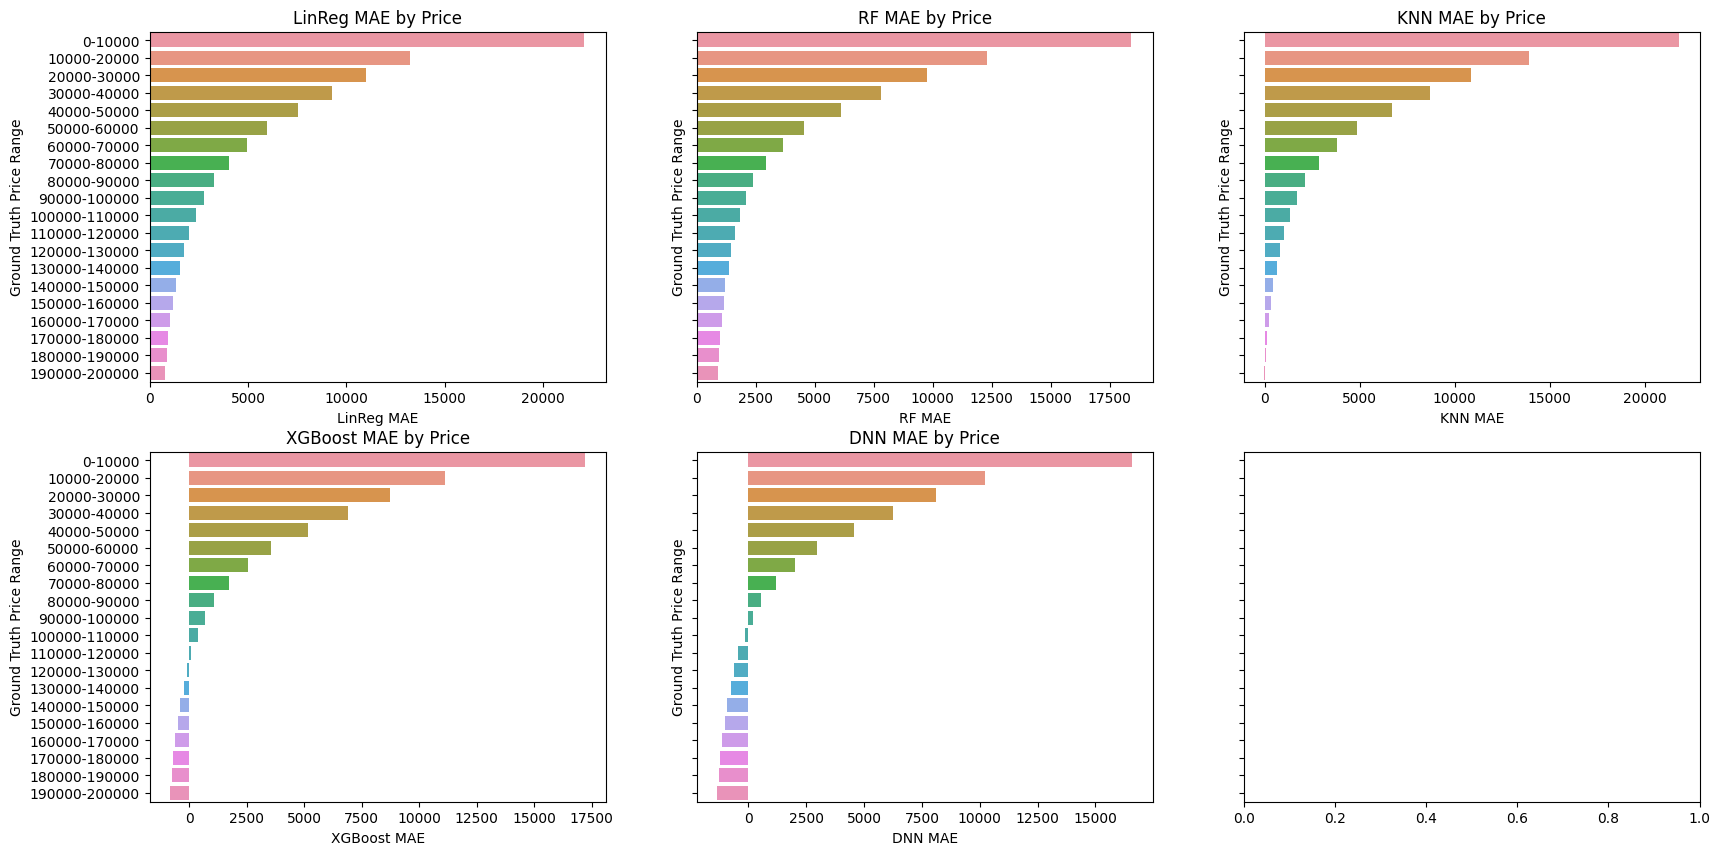

In [ ]:
get_scatter(pred_df)